<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/img_processing/stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study to find STOP signals in images

Steps


*   Filter red parts
*   Find contours
*   Select octogon contours


In [1]:
import numpy as np
import skimage
from matplotlib import pyplot as plt

First we download an image with stop signal.

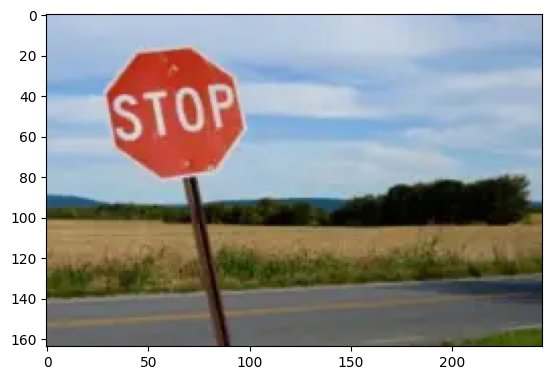

In [2]:
orig_img  = skimage.io.imread('https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp')
skimage.io.imsave('stop.jpg', orig_img)
# remove noise
#img = skimage.filters.gaussian(orig_img, 1)    # it may help
img = orig_img
fig, ax = plt.subplots()
ax.imshow(orig_img)
#ax[1].imshow(img)
#plt.imshow(img)
#plt.axis("off")

We convert the RGB image to HSV space to separate different shades of red. skimage scale HSV values to (0,1) interval.

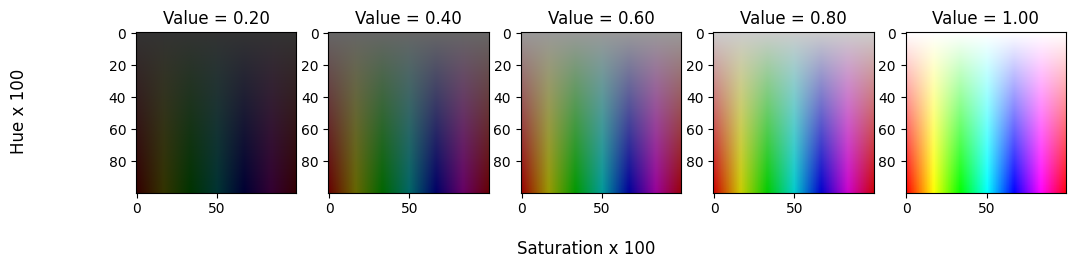

In [22]:
img_hsv = skimage.color.rgb2hsv(img)
isize = 100
h_scale = np.zeros((isize, isize, 3), dtype=img_hsv.dtype)
h = np.arange(0.0, 1.0, 1 / h_scale.shape[1])
for i in range(isize):
        h_scale[i,:,0] = h
        h_scale[:,i,1] = h
icols = 5
fig, ax = plt.subplots(ncols=icols, figsize=(12, 3))
fig.supxlabel('Saturation x 100')
fig.supylabel('Hue x 100')
for i in range(icols):
    v = i / icols + 0.20
    h_scale[:,:,2] = v
    ax[i].imshow(skimage.color.hsv2rgb(h_scale))
    ax[i].set_title(f'Value = {v:.2f}')

The hue should be greater than 0.6 and the saturation should be less than 0.1 for red color.

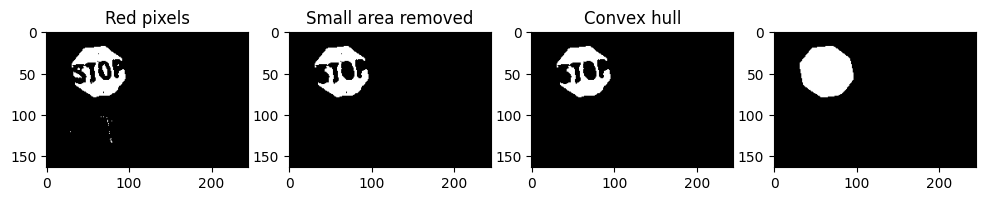

In [27]:
#img_bin = ((img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) | # red pixels
#            ((img_hsv[:,:,0] < 0.2) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] < 0.3) & (img_hsv[:,:,2] > 0.8)) # white pixels
img_bin = (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) # red pixels
fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
ax[0].set_title('Red pixels')
ax[0].imshow(img_bin, cmap='gray')
img_bin = skimage.morphology.remove_small_objects(img_bin)
ax[1].set_title('Small area removed')
ax[1].imshow(img_bin, cmap='gray')
img_bin = skimage.morphology.remove_small_holes(img_bin, 200)
ax[2].set_title('Small holes removed')
ax[2].imshow(img_bin, cmap='gray')
img_bin = skimage.morphology.convex_hull_image(img_bin) # TODO not useful if more signals are in the same image
ax[2].set_title('Convex hull')
ax[3].imshow(img_bin, cmap='gray')

(12, 2)
Stop signal at 53.4, 63.3


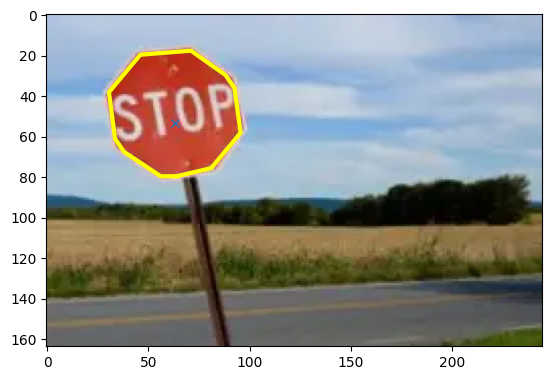

In [23]:
cnts = skimage.measure.find_contours(img_bin)
fig, ax = plt.subplots()
ax.imshow(img)
for contour in cnts:
    appr = skimage.measure.approximate_polygon(contour, tolerance=1.5)
    print(appr.shape)
    if 7 < appr.shape[0] < 14:
        ax.plot(appr[:,1], appr[:, 0], c="yellow", linewidth=3)
        center = np.mean(appr, axis=0)
        ax.plot(center[1], center[0], 'x')
        print(f"Stop signal at {center[0]:.1f}, {center[1]:.1f}")


Finaly test our algorithm with different images.
For this let's create a function for the simplicity.


In [28]:
from scipy.spatial import ConvexHull
def stop_signs(img):
    """ find stop traffic signal in image
        return a numpy array with the positions of the possible stop traffic signals
    """
    img_hsv = skimage.color.rgb2hsv(img)
    img_bin = (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) # red pixels
    img_bin = skimage.morphology.remove_small_objects(img_bin)
    img_bin = skimage.morphology.remove_small_holes(img_bin, 200)
    cnts = skimage.measure.find_contours(img_bin)
    res = []
    for contour in cnts:
        appr = skimage.measure.approximate_polygon(contour, tolerance=1.5)
        appr = ConvexHull(appr)
        res.append(np.mean(appr, axis=0)
    return res